# BCycle Austin models

This notebook concludes the BCycle Austin series of blog posts, and looks at how machine learning could be used to help the BCycle team. I'll be using weather data in addition to the station and bike information, and building models which I hope might be useful. Let's get started !

## Imports and data loading

Before getting started, let's import some useful libraries for visualization, and the bcycle utils library.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import seaborn as sns

import datetime

from bcycle_lib.utils import *

%matplotlib inline
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Loading weather and rental data


In [2]:
bikes_df = load_bikes()
stations_df = load_stations()
weather_df = load_weather()

# Modelling bike rentals by day

In this section, I'll be using machine learning to predict how many bike rentals there are in each day. As this is a time series problem, I'll split the dataset as follows. This gives roughly a 70% training - 30% validation data split.

* Training: 1st April to 15th May (6 complete weeks of data).
* Validation: 16th May to 31st May (2 complete weeks of data).

I'll create a couple of simple baselines first, which just use previous rental numbers directly. If our machine learning models can't beat this, there's a problem! After that, I'll use time-series forecasting, and then linear regression.

In [3]:
# First create a daily rentals dataframe, split it into training and validation
rentals_df = load_daily_rentals()
train_df = rentals_df['2016-04-01':'2016-05-15']
val_df = rentals_df['2016-05-16':'2016-05-31']

print('\nTraining data head:\n{}'.format(train_df.head()))
print('\nValidation data head:\n{}'.format(val_df.head()))


Training data head:
            rentals
date               
2016-04-01    353.0
2016-04-02    853.0
2016-04-03    818.0
2016-04-04    525.0
2016-04-05    563.0

Validation data head:
            rentals
date               
2016-05-16    503.0
2016-05-17    405.0
2016-05-18    540.0
2016-05-19    273.0
2016-05-20    847.0


# Baseline - predict daily checkouts using median

To start off with, let's just predict the median amount of checkouts, and see how the RMSE looks.

In [4]:
median_df = train_df.copy()
median = median_df['rentals'].median()

median_pred_df = val_df.copy()
median_pred_df['predicted'] = median

median_pred_df.head()

,rentals,predicted
date,,
2016-05-16,503.0,501.0
2016-05-17,405.0,501.0
2016-05-18,540.0,501.0
2016-05-19,273.0,501.0
2016-05-20,847.0,501.0


## Helper functions

Let's define some helper functions, which are used in the code below. We'll be running these steps multiple times for each model, so it saves copying and pasting.

In [5]:
def RMSE(pred, true):
    '''
    Calculates Root-Mean-Square-Error using predicted and true
    columns of pandas dataframe
    INPUT: pred and true pandas columns
    RETURNS: float of RMSE
    '''
    rmse = np.sqrt(np.sum((pred - true).apply(np.square)) / pred.shape[0])
    return rmse

def plot_prediction(df, pred_col, true_col, title):
    '''
    Plots the predicted rentals along with actual rentals for the dataframe
    INPUT: df - pandas dataframe containing predicted and true columns
           pred_col - string with prediction column name
           true_col - string with actual column name
    RETURNS: Nothing
    '''
    fig, ax = plt.subplots(1,1, figsize=(18,10))
    ax = df.plot(y=[pred_col, true_col], ax=ax, color='black', style=['--', '-'])
    ax.set_xlabel('Date', fontdict={'size' : 14})
    ax.set_ylabel('Rentals', fontdict={'size' : 14})
    ax.set_title(title, fontdict={'size' : 18}) 
    ttl = ax.title
    ttl.set_position([.5, 1.02])
    ax.legend(['Predicted rentals', 'Actual rentals'], fontsize=14)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
#     ax.set_xticklabels(df.index.strftime('%a %b %d'))

Median baseline RMSE: 275.72


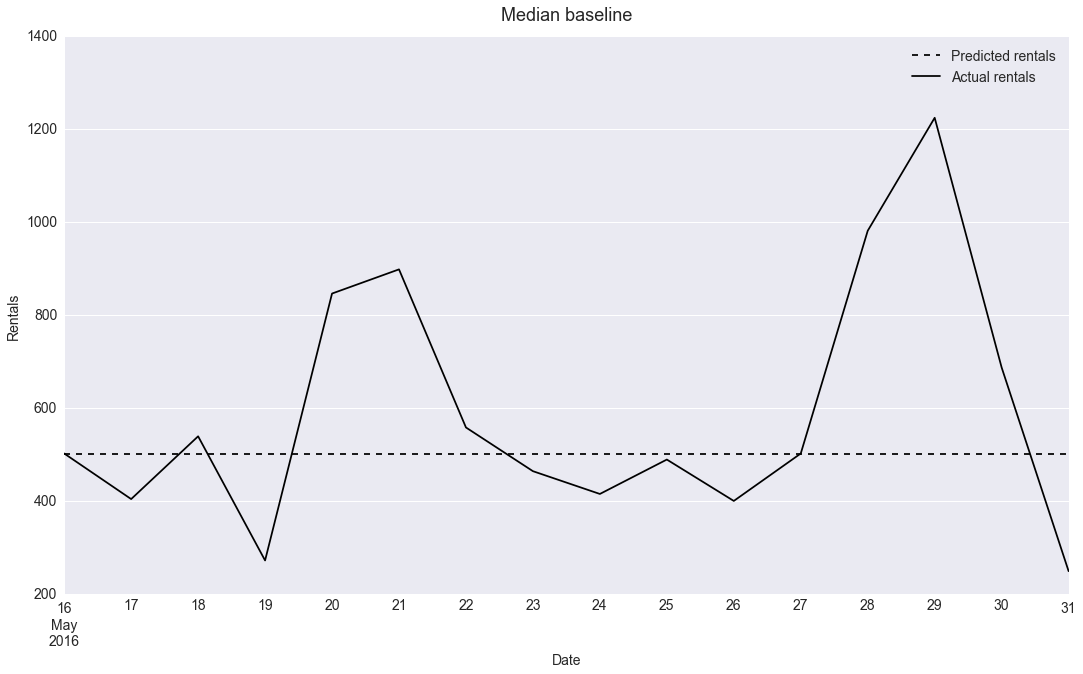

In [6]:
# Store the results of the median RMSE and plot prediction
median_rmse = RMSE(median_pred_df['predicted'], median_pred_df['rentals'])

scores = dict() # Store the model scores in here
scores['median'] = median_rmse

print('Median baseline RMSE: {:.2f}'.format(median_rmse))
plot_prediction(median_pred_df, 'predicted', 'rentals', title='Median baseline')

By predicting the median amount of rentals for each day, we end up with an RMSE of 276. This means on average in each of the days we're 275 bikes off the actual rental amount. You can see on the plot the static line doesn't track the daily variations in rentals. What if we take the median for each day independently ..?

# Baseline - predict daily rentals using median for day-of-week

To improve on the previous fixed median baseline, we can calculate the median rentals for each day separately in the training set. Then for the days in the test set just use that median value for the prediction. This is a simplistic approach which assumes that every day has similar amounts of rentals.

In [7]:
# Calculate the median amount of checkouts by day of week from the training data
dow_df = train_df.copy()
dow_df = dow_df.reset_index()
dow_df['dayofweek'] = dow_df['date'].dt.dayofweek
dow_df = dow_df.groupby('dayofweek').median().reset_index()
dow_df

,dayofweek,rentals
0,0,488.0
1,1,455.5
2,2,451.0
3,3,481.0
4,4,671.0
5,5,853.0
6,6,669.0


In [8]:
# Use the day-of-week to join the predictions into the validation set, and calculate difference
dow_pred_df = val_df.copy()
dow_pred_df = dow_pred_df.reset_index()
dow_pred_df['dayofweek'] = dow_pred_df['date'].dt.dayofweek
dow_pred_df = pd.merge(dow_pred_df, dow_df, on='dayofweek', how='left', suffixes=('_true', '_pred'))
dow_pred_df['diff'] = dow_pred_df['rentals_pred'] - dow_pred_df['rentals_true']
dow_pred_df.index = dow_pred_df['date']
dow_pred_df = dow_pred_df.drop(['date', 'dayofweek'], axis=1)
dow_pred_df.head()

,rentals_true,rentals_pred,diff
date,,,
2016-05-16,503.0,488.0,-15.0
2016-05-17,405.0,455.5,50.5
2016-05-18,540.0,451.0,-89.0
2016-05-19,273.0,481.0,208.0
2016-05-20,847.0,671.0,-176.0


Now we have predictions for each of the days in the validation set, we can calculate our error metric (Root-Mean-Square-Error) and plot our predictions to see how we did with the simplistic baseline.

Day-of-week median baseline RMSE: 184.63


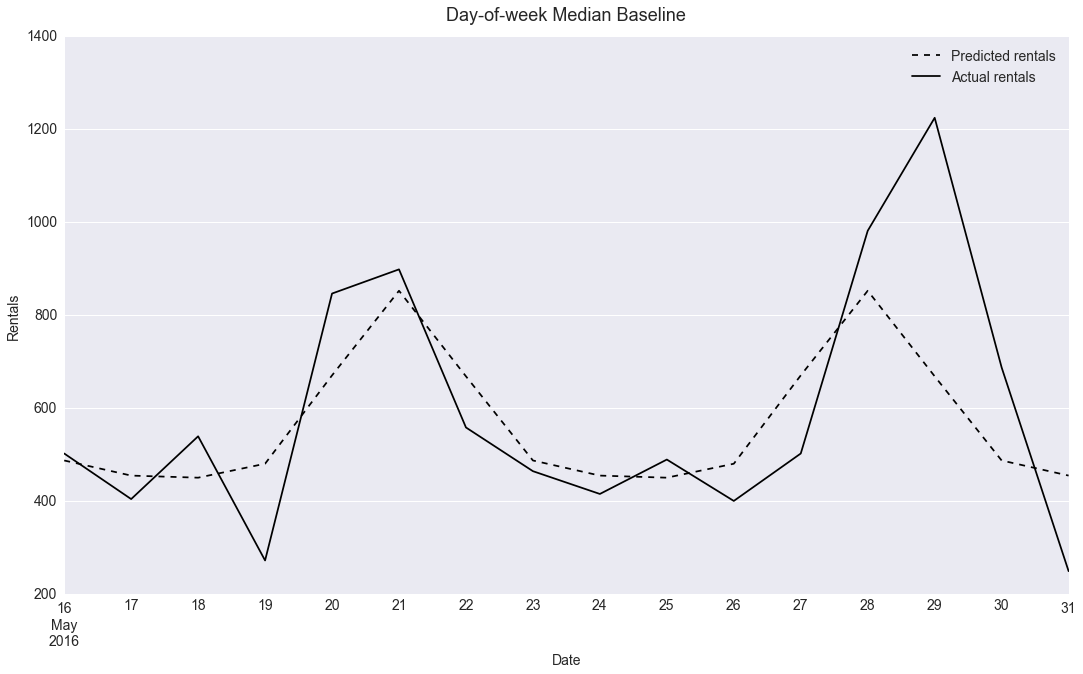

In [9]:
# Calculate the RMSE
pred = dow_pred_df['rentals_pred']
true = dow_pred_df['rentals_true']
dow_rmse = np.sqrt(np.sum((pred - true).apply(np.square)) / pred.shape[0])

scores['dow_median'] = dow_rmse
print('Day-of-week median baseline RMSE: {:.2f}'.format(dow_rmse))
plot_prediction(dow_pred_df, 'rentals_pred', 'rentals_true', title='Day-of-week Median Baseline')

The RMSE for the baseline prediction is 185. This shows that each day, we're off by an average of 185 bikes using this simple benchmark. The plot shows the prediction is actually not far off before the 28th May, which is the Memorial Day weekend. On the 29th May alone, our baseline is off by 550 rentals though.

# Linear models - Time

Now we have some baselines to compare against, let's use a [Linear Regression](https://en.wikipedia.org/wiki/Linear_regression) model to predict the daily rentals in the last couple of weeks of the validation dataset. We'll be using the excellent [scikit-learn](http://scikit-learn.org/stable/) library, which has a wide range of [linear models](http://scikit-learn.org/stable/modules/linear_model.html) we can use. First of all, let's do some manipulation on the pandas datasets for model training and validation.

In [10]:
from sklearn import preprocessing

# First let's add some features to help the model out
def add_date_features(input_df):
    '''Adds day-of-week, weekend, and lagged rentals
    INPUT: Dataframe with datetime index
    RETURNS: Copy of dataframe with extra features
    '''
    df = input_df.copy()
    df = df.reset_index()
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekend'] = df['dayofweek'] < 5
    df['prev_rentals'] = df['rentals'].shift(+1)
    df.loc[0, 'prev_rentals'] = df.loc[0, 'rentals']
    df['prev_week_rentals'] = df['rentals'].shift(+7)
    df.loc[0:6, 'prev_week_rentals'] = df.loc[0:6, 'rentals']
    return df

def reg_x_y_split(df):
    ''' Returns X and y to train regressor
    INPUT: Dataframe to be converted to numpy arrays 
    RETURNS: Tuple with X and y
    '''
    # Need to convert dayofweek to one-hot value
    lbe = preprocessing.LabelBinarizer()
    dayofweek = lbe.fit_transform(df['dayofweek'])
    
    # Split target and features
    X = np.hstack((df[['weekend', 'prev_rentals']].values, dayofweek))
    y = df['rentals'].values

    return X, y

In [11]:
# Create new time-based features, numpy arrays to train model
reg_train_df = add_date_features(train_df)
reg_val_df = add_date_features(val_df)

X_train, y_train = reg_x_y_split(reg_train_df)
X_val, y_val = reg_x_y_split(reg_val_df)

print('X_train shape: {}, y_train shape: {}'.format(X_train.shape, y_train.shape))
print('X_val shape: {}, y_val shape: {}'.format(X_val.shape, y_val.shape))

X_train shape: (45, 9), y_train shape: (45,)
X_val shape: (16, 9), y_val shape: (16,)


In [12]:
# Linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

reg = LinearRegression()
reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
reg_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

y_val_pred = reg.predict(X_val)
reg_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

scores['reg_train_rmse'] = reg_train_rmse
scores['reg_val_rmse'] = reg_val_rmse

print('Regression RMSE - Train: {:.2f}, Val: {:.2f}'.format(reg_train_rmse, reg_val_rmse))

Regression RMSE - Train: 131.71, Val: 205.92


In [13]:
def df_from_results(index_train, y_train, y_train_pred, index_val, y_val, y_val_pred):
    
    train_dict = dict()
    val_dict = dict()

    train_dict['true'] = y_train
    train_dict['pred'] = y_train_pred

    val_dict['true'] = y_val
    val_dict['pred'] = y_val_pred

    train_df = pd.DataFrame(train_dict)
    val_df = pd.DataFrame(val_dict)

    train_df.index = index_train
    val_df.index = index_val
    
    return train_df, val_df
    
reg_result_train_df, reg_result_val_df = df_from_results(reg_train_df['date'], y_train, y_train_pred,
                                                         reg_val_df['date'], y_val, y_val_pred)
 

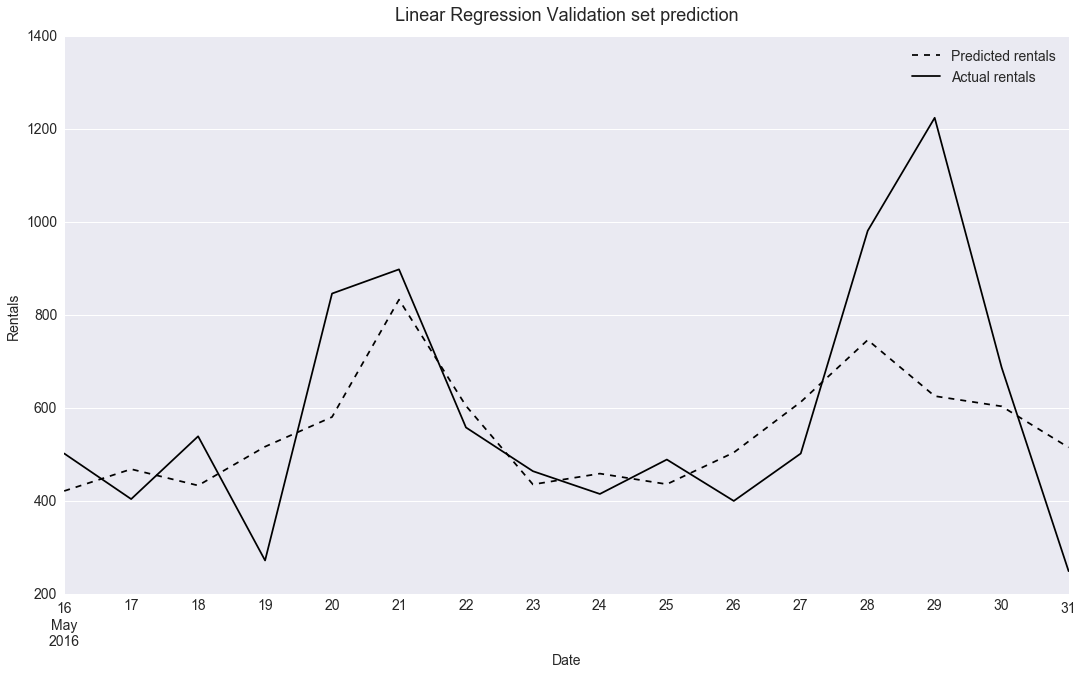

In [14]:
# plot_prediction(reg_result_train_df, 'pred', 'true', title='Training set prediction')
plot_prediction(reg_result_val_df, 'pred', 'true', title='Linear Regression Validation set prediction')

# Linear Models - Time and Weather

To improve on the previous results, we can use the weather conditions to give the model extra information. First of all, we can do a naive approach and merge in all weather data to see how this changes the performance of the model.

In [15]:
train_weather_df = pd.merge(train_df, weather_df, left_index=True, right_index=True)
val_weather_df = pd.merge(val_df, weather_df, left_index=True, right_index=True)

train_weather_df = add_date_features(train_weather_df)
val_weather_df = add_date_features(val_weather_df)

train_weather_df = train_weather_df.drop('date', axis=1)
val_weather_df = val_weather_df.drop('date', axis=1)

In [16]:
def reg_weather_x_y_split(df):
    ''' Returns X and y to train regressor
    INPUT: Dataframe to be converted to numpy arrays 
    RETURNS: Tuple with X and y
    '''
    df_index = df.columns[0]
    df = df.reset_index()
    df.drop(df_index, axis=1)
    # Need to convert dayofweek to one-hot value
    lbe = preprocessing.LabelBinarizer()
    dayofweek = lbe.fit_transform(df['dayofweek'])
    # Split target and features
    X = np.hstack((df.drop('rentals', axis=1).values, dayofweek))
    y = df['rentals'].values

    return X, y

X_train, y_train = reg_weather_x_y_split(train_weather_df)
X_val, y_val = reg_weather_x_y_split(val_weather_df)

print('X_train shape: {}, y_train shape: {}'.format(X_train.shape, y_train.shape))
print('X_val shape: {}, y_val shape: {}'.format(X_val.shape, y_val.shape))

X_train shape: (45, 26), y_train shape: (45,)
X_val shape: (16, 26), y_val shape: (16,)


Weather Regression RMSE - Train: 89.60, Val: 205.82


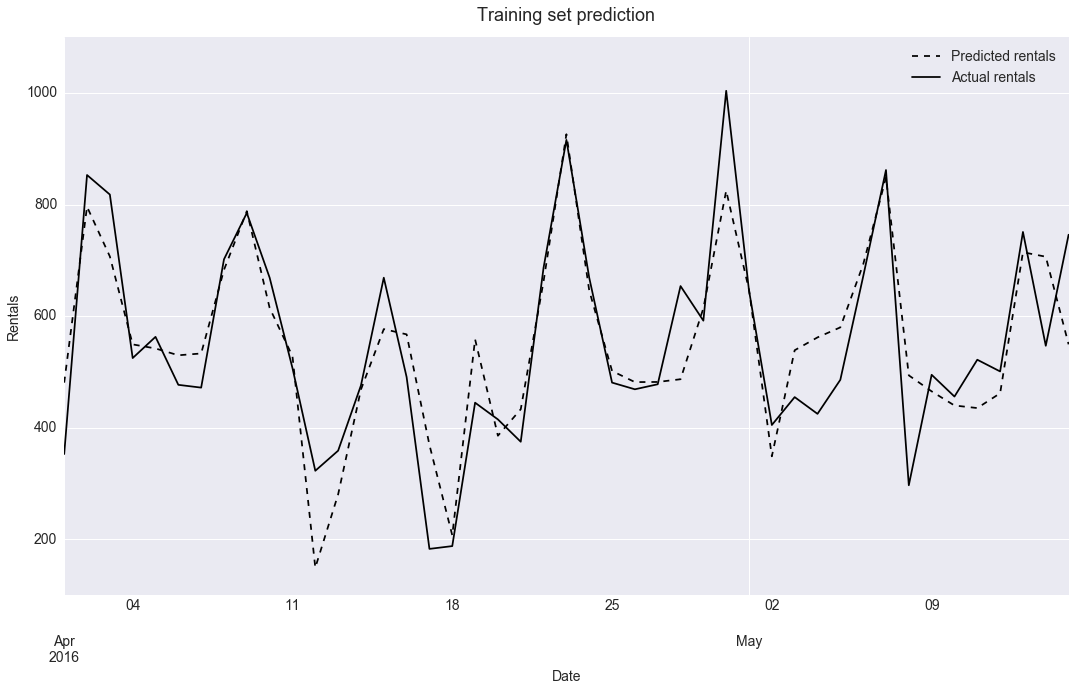

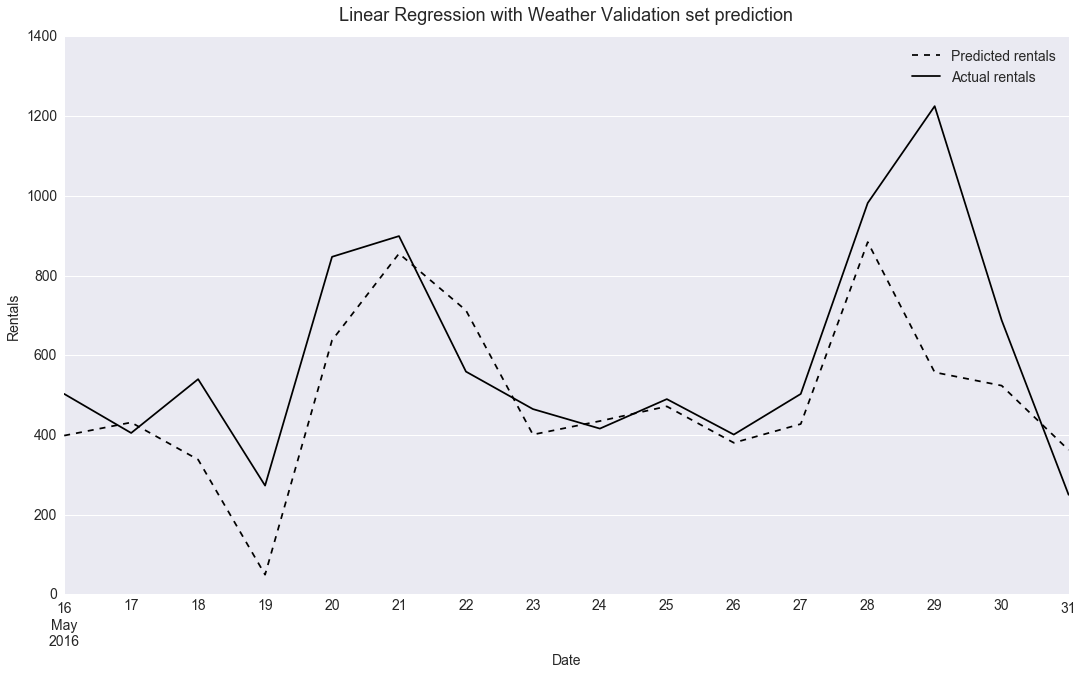

In [17]:
reg = LinearRegression()
reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
reg_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

y_val_pred = reg.predict(X_val)
reg_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

scores['weather_reg_train_rmse'] = reg_train_rmse
scores['weather_reg_val_rmse'] = reg_val_rmse

print('Weather Regression RMSE - Train: {:.2f}, Val: {:.2f}'.format(reg_train_rmse, reg_val_rmse))

reg_result_train_df, reg_result_val_df = df_from_results(train_df.index, y_train, y_train_pred,
                                                         val_df.index, y_val, y_val_pred)

plot_prediction(reg_result_train_df, 'pred', 'true', title='Training set prediction')
plot_prediction(reg_result_val_df, 'pred', 'true', title='Linear Regression with Weather Validation set prediction')

# Linear Models - Time and Weather with Feature Engineering

The results of the linear models with time and weather show a case of overfitting. The training set RMSE is 90 which is better than all other models so far. But the validation set shows a much worse RMSE of 205. This is worse than the baseline day-of-week median model !

Before addressing the overfitting, we need to remove features which are highly correlated with each other. To make sure we don't cheat by checking the validation set distribution, we'll only use the training set.

* rentals: Target variable we're predicting
* max_temp: Correlated to rentals, not correlated to min_temp
* min_temp: Correlated to rentals also.
* ~~max_humidity~~: Both max humidity and min humidity have the same negative correlation with rentals.
* ~~min_humidity~~: Both max humidity and min humidity have the same negative correlation with rentals.
* ~~max_pressure~~: 
* ~~min_pressure~~: 
* ~~max_wind~~: Strongly correlated with max_gust
* ~~min_wind~~: Strongly correlated with max_gust
* max_gust: Correlated to other wind values, and to rentals value
* precipitation: Heavily right skewed, needs transform
* cloud_pct: 
* rain: 
* thunderstorm: 
* ~~fog~~: Not correlated with rentals at all
* dayofweek
* weekend
* prev_rentals

In [18]:
from sklearn.preprocessing import StandardScaler

def reg_weather_feat_x_y_split(df):
    ''' Returns X and y to train regressor
    INPUT: Dataframe to be converted to numpy arrays 
    RETURNS: Tuple with X and y
    '''
    cols = ['rentals', 'max_temp', 'min_temp', 'max_gust', 'precipitation', 
         'cloud_pct', 'rain', 'thunderstorm', 'dayofweek', 'weekend', 'prev_rentals']

    df = df[cols]
    # Need to convert dayofweek to one-hot value
    lbe = preprocessing.LabelBinarizer()
    dayofweek = lbe.fit_transform(df['dayofweek'])
    # Split target and features
    X = np.hstack((df.drop('rentals', axis=1).values, dayofweek))
    y = df['rentals'].values

    return X, y

X_train, y_train = reg_weather_feat_x_y_split(train_weather_df)
X_val, y_val = reg_weather_feat_x_y_split(val_weather_df)

print('X_train columns: {}'.format(train_weather_df.columns))
print('X_train shape: {}, y_train shape: {}'.format(X_train.shape, y_train.shape))
print('X_val shape: {}, y_val shape: {}'.format(X_val.shape, y_val.shape))

X_train columns: Index(['rentals', 'max_temp', 'min_temp', 'max_humidity', 'min_humidity',
       'max_pressure', 'min_pressure', 'max_wind', 'min_wind', 'max_gust',
       'precipitation', 'cloud_pct', 'thunderstorm', 'rain', 'fog',
       'dayofweek', 'weekend', 'prev_rentals', 'prev_week_rentals'],
      dtype='object')
X_train shape: (45, 17), y_train shape: (45,)
X_val shape: (16, 17), y_val shape: (16,)


Weather Feature Regression RMSE - Train: 95.15, Val: 163.69


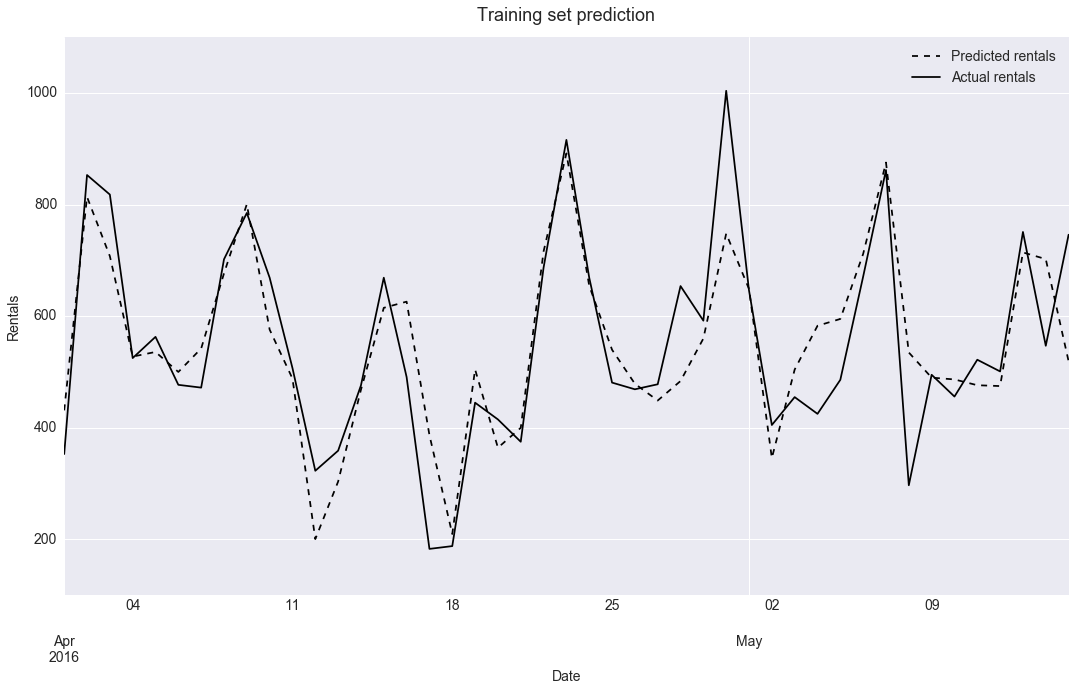

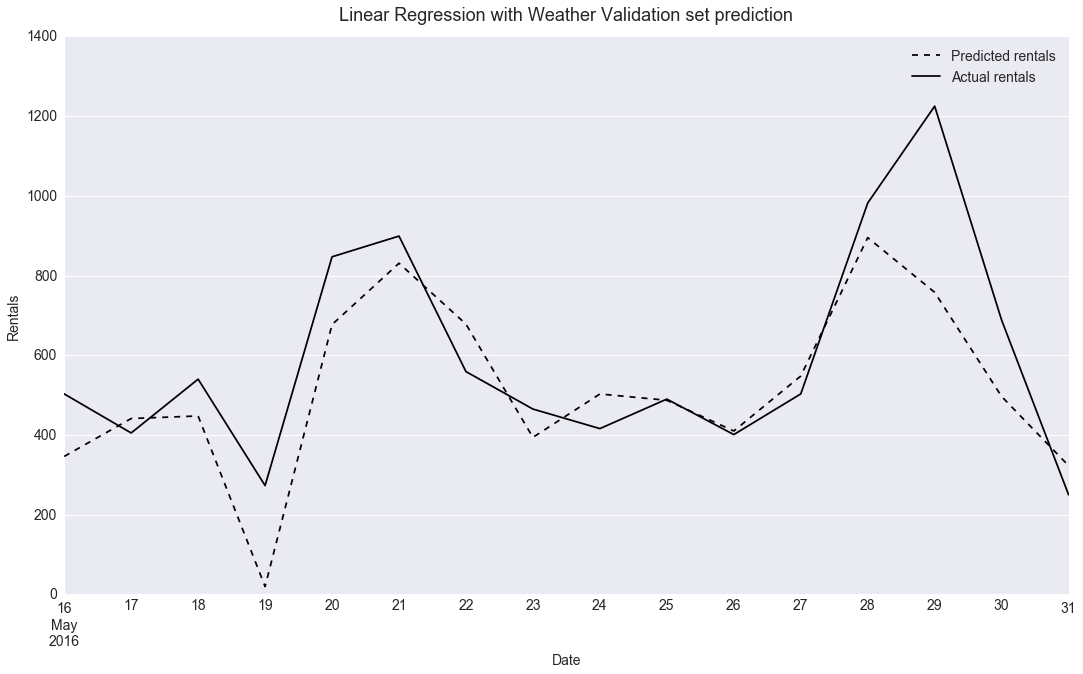

In [19]:
reg = LinearRegression()
reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
reg_weather_feat_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

y_val_pred = reg.predict(X_val)
reg_weather_feat_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

scores['weather_reg_feat_train_rmse'] = reg_weather_feat_train_rmse
scores['weather_reg_feat_val_rmse'] = reg_weather_feat_val_rmse

print('Weather Feature Regression RMSE - Train: {:.2f}, Val: {:.2f}'.format(reg_weather_feat_train_rmse, reg_weather_feat_val_rmse))

reg_result_train_df, reg_result_val_df = df_from_results(train_df.index, y_train, y_train_pred,
                                                         val_df.index, y_val, y_val_pred)

plot_prediction(reg_result_train_df, 'pred', 'true', title='Training set prediction')
plot_prediction(reg_result_val_df, 'pred', 'true', title='Linear Regression with Weather Validation set prediction')

In [20]:
scores

{'dow_median': 184.62694650294145,
 'median': 275.7220067386715,
 'reg_train_rmse': 131.71384098587532,
 'reg_val_rmse': 205.91635061814662,
 'weather_reg_feat_train_rmse': 95.149322126609022,
 'weather_reg_feat_val_rmse': 163.69335812484522,
 'weather_reg_train_rmse': 89.595751818286473,
 'weather_reg_val_rmse': 205.81750260962201}

# Linear Models - Model Tuning

Now the features seem to be in good shape, we can try some different models to see which gives the best results.

,alpha,train_rmse,test_rmse
0,0.01,95.149630,163.563619
1,0.10,95.177320,162.532753
2,1.00,96.524452,158.866380
3,10.00,108.198708,166.074248


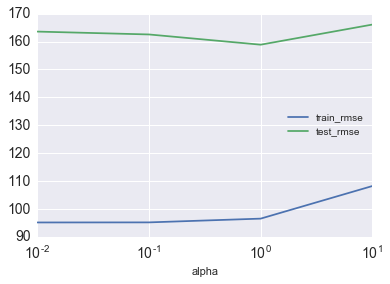

In [21]:
from sklearn.linear_model import Ridge

alphas = [0.01, 0.1, 1.0, 10.0]
ridge_cv_scores = dict()

for alpha in alphas:
    reg = Ridge(alpha=alpha, max_iter=10000)
    reg.fit(X_train, y_train)
    y_train_pred = reg.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

    y_val_pred = reg.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    ridge_cv_scores[alpha] = (train_rmse, val_rmse)

ridge_cv_df = pd.DataFrame(ridge_cv_scores).transpose().reset_index()
ridge_cv_df.columns = ['alpha', 'train_rmse', 'test_rmse']
ridge_cv_df.plot.line(x='alpha', y=['train_rmse', 'test_rmse'], logx=True)
ridge_cv_df

,alpha,train_rmse,test_rmse
0,0.01,95.149385,163.630619
1,0.10,95.155243,163.113720
2,1.00,95.725313,159.388936
3,10.00,112.992442,171.941348


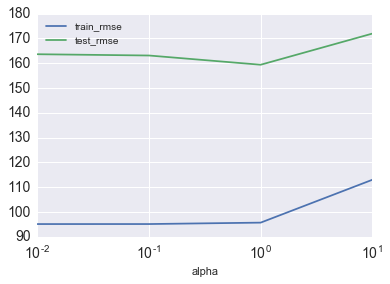

In [22]:
from sklearn.linear_model import Lasso

alphas = [0.01, 0.1, 1.0, 10.0]
ridge_cv_scores = dict()

for alpha in alphas:
    reg = Lasso(alpha=alpha, max_iter=10000)
    reg.fit(X_train, y_train)
    y_train_pred = reg.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

    y_val_pred = reg.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    ridge_cv_scores[alpha] = (train_rmse, val_rmse)

lasso_cv_df = pd.DataFrame(ridge_cv_scores).transpose().reset_index()
lasso_cv_df.columns = ['alpha', 'train_rmse', 'test_rmse']
lasso_cv_df.plot.line(x='alpha', y=['train_rmse', 'test_rmse'], logx=True)
lasso_cv_df

# Linear Models - Wrapup